In [15]:
# Main libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# ETL libraries
from ETL import ETL

# Scikit-learn: Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

# Scikit-learn: Models
from sklearn.ensemble import (
    AdaBoostClassifier, 
    GradientBoostingClassifier, 
    RandomForestClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Scikit-learn: Testing and evaluation
from sklearn.metrics import (
    accuracy_score, 
    auc, 
    classification_report, 
    confusion_matrix, 
    log_loss, 
    roc_curve,
    roc_auc_score
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split


In [16]:
df = pd.read_csv('dataset/flights.csv')

In [17]:
df = ETL(df)

In [5]:
df.columns

Index(['OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'DEP_DELAY',
       'TAXI_OUT', 'TAXI_IN', 'ARR_DELAY', 'CANCELLED', 'DIVERTED',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'ACT_TO_CRS_RATIO', 'FL_MON', 'FL_DAY', 'FL_YEAR', 'FL_DOW',
       'CRS_DEP_TIME_HOUR', 'CRS_DEP_TIME_MIN', 'DEP_TIME_HOUR',
       'DEP_TIME_MIN', 'WHEELS_OFF_HOUR', 'WHEELS_OFF_MIN', 'WHEELS_ON_HOUR',
       'WHEELS_ON_MIN', 'CRS_ARR_TIME_HOUR', 'CRS_ARR_TIME_MIN',
       'ARR_TIME_HOUR', 'ARR_TIME_MIN', 'CANCELLATION_REASON'],
      dtype='object')

# ETL for classification

In [18]:
def categorize_delay(row):
    arr_delay = row['ARR_DELAY']
    cancelled = row['CANCELLED']
    diverted = row['DIVERTED']
    
    if cancelled == 1:
        return 6  # Volo cancellato
    
    if diverted == 1:
        return 5  # Volo deviato
    
    if arr_delay < 0:
        return 0  # Volo in anticipo
    
    if arr_delay == 0:
        return 1  # Volo puntuale
    
    if 0 < arr_delay <= 15:
        return 2  # Ritardo breve
    
    if 15 < arr_delay <= 60:
        return 3  # Ritardo medio
    
    if arr_delay > 60:
        return 4  # Ritardo lungo
    
    return 7  # Caso non definito (eventuali dati mancanti o errati)

df['FLIGHT_STATUS'] = df.apply(categorize_delay, axis=1)

In [11]:
df['FLIGHT_STATUS'].value_counts()

FLIGHT_STATUS
0    70766
2    22517
3    14702
4     6420
1     2672
6     1902
5      292
Name: count, dtype: int64

In [19]:
# Variabili temporali da trasformare (ciclo orario)
time_features = [
    'DEP_TIME_HOUR', 'DEP_TIME_MIN', 'ARR_TIME_HOUR', 'ARR_TIME_MIN',
    'CRS_DEP_TIME_HOUR', 'CRS_DEP_TIME_MIN', 'CRS_ARR_TIME_HOUR', 'CRS_ARR_TIME_MIN',
    'FL_MON', 'FL_DOW', 'FL_YEAR', 'FL_DAY'
]

# Funzione per ottenere il numero di giorni in un mese
def days_in_month(month, year):
    # Usa un calendario per determinare il numero di giorni nel mese
    if month == 2:
        # Se è febbraio, considera l'anno bisestile
        return 29 if (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)) else 28
    elif month in [4, 6, 9, 11]:
        return 30  # Aprile, Giugno, Settembre, Novembre
    else:
        return 31  # Gennaio, Marzo, Maggio, Luglio, Agosto, Ottobre, Dicembre

# Funzione per encoding ciclico delle variabili temporali
def encode_cyclic_features(df, feature, max_val):
    df[f'{feature}_sin'] = np.sin(2 * np.pi * df[feature] / max_val)
    df[f'{feature}_cos'] = np.cos(2 * np.pi * df[feature] / max_val)
    return df

# Funzione per encoding ciclico specifico per FL_DAY con il numero effettivo di giorni nel mese
def encode_cyclic_day_features(df):
    # Calcolare il numero di giorni per ogni mese e anno
    df['days_in_month'] = df.apply(lambda row: days_in_month(row['FL_MON'], row['FL_YEAR']), axis=1)
    
    # Creare la codifica ciclica per FL_DAY
    df['FL_DAY_sin'] = np.sin(2 * np.pi * df['FL_DAY'] / df['days_in_month'])
    df['FL_DAY_cos'] = np.cos(2 * np.pi * df['FL_DAY'] / df['days_in_month'])
    
    # Rimuovere la colonna intermedia 'days_in_month'
    df = df.drop(columns=['days_in_month'])
    
    return df

# Mappatura delle variabili temporali e dei loro massimi
feature_map = {
    'DEP_TIME_HOUR': 24, 'ARR_TIME_HOUR': 24, 'CRS_DEP_TIME_HOUR': 24, 'CRS_ARR_TIME_HOUR': 24,
    'DEP_TIME_MIN': 60, 'ARR_TIME_MIN': 60, 'CRS_DEP_TIME_MIN': 60, 'CRS_ARR_TIME_MIN': 60,
    'FL_MON': 12, 'FL_DOW': 7, 'FL_YEAR': 1  # FL_YEAR sarà normalizzato separatamente
}

# Trasformazioni cicliche per le variabili temporali
for feature, max_val in feature_map.items():
    if feature in df.columns:
        df = encode_cyclic_features(df, feature, max_val)

# Applicare l'encoding ciclico specifico per FL_DAY
df = encode_cyclic_day_features(df)

# Creare il MinMaxScaler per FL_YEAR
scaler = MinMaxScaler()

# Applicare la normalizzazione e mantenere il formato DataFrame
df[['FL_YEAR']] = scaler.fit_transform(df[['FL_YEAR']])

# Rimozione delle colonne temporali originali (opzionale)
df = df.drop(columns=time_features, errors='ignore')

In [20]:
# Variabili da normalizzare (senza outliers significativi)
min_max_features = [
    'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE'
]

# Inizializzazione degli scaler
min_max_scaler = MinMaxScaler()

# Normalizzazione delle variabili senza outliers significativi
df[min_max_features] = min_max_scaler.fit_transform(df[min_max_features])

In [21]:
# Variabili da standardizzare (con possibili outliers)
standard_features = [
    'DEP_DELAY', 'ARR_DELAY', 'TAXI_OUT', 'TAXI_IN', 'ACT_TO_CRS_RATIO'
]

standard_scaler = StandardScaler()

# Standardizzazione delle variabili con outliers
df[standard_features] = standard_scaler.fit_transform(df[standard_features])

In [22]:
# Create dummies - for better model outcomes
df = pd.get_dummies(df)

In [23]:
df = df.drop(columns='OP_CARRIER_FL_NUM', errors='ignore')

# Replace NaNs with a placeholder category
df.fillna(False, inplace=True)
df.head()

,DEP_DELAY,TAXI_OUT,TAXI_IN,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,...,DEST_WRG,DEST_WYS,DEST_XNA,DEST_YAK,DEST_YUM,CANCELLATION_REASON_Airline/Carrier,CANCELLATION_REASON_National Air System,CANCELLATION_REASON_Not cancelled,CANCELLATION_REASON_Security,CANCELLATION_REASON_Weather
0,-0.348998,-1.034093,-0.930735,-0.553123,0.0,0.0,0.097331,0.101979,0.093651,0.067447,...,False,False,False,False,False,False,False,True,False,False
1,-0.047320,-0.288502,-0.375531,-0.113951,0.0,0.0,0.054945,0.070015,0.044444,0.020800,...,False,False,False,False,False,False,False,True,False,False
2,-0.403849,0.457088,-0.560599,-0.062284,0.0,0.0,0.356358,0.385084,0.363492,0.331785,...,False,False,False,False,False,False,False,True,False,False
3,-0.239297,-0.288502,-0.560599,-0.553123,0.0,0.0,0.318681,0.310502,0.296825,0.265751,...,False,False,False,False,False,False,False,True,False,False
4,-0.376424,-0.608041,-0.005395,-0.398121,0.0,0.0,0.185243,0.197869,0.179365,0.155695,...,False,False,False,False,False,False,False,True,False,False


# Correlation Analysis

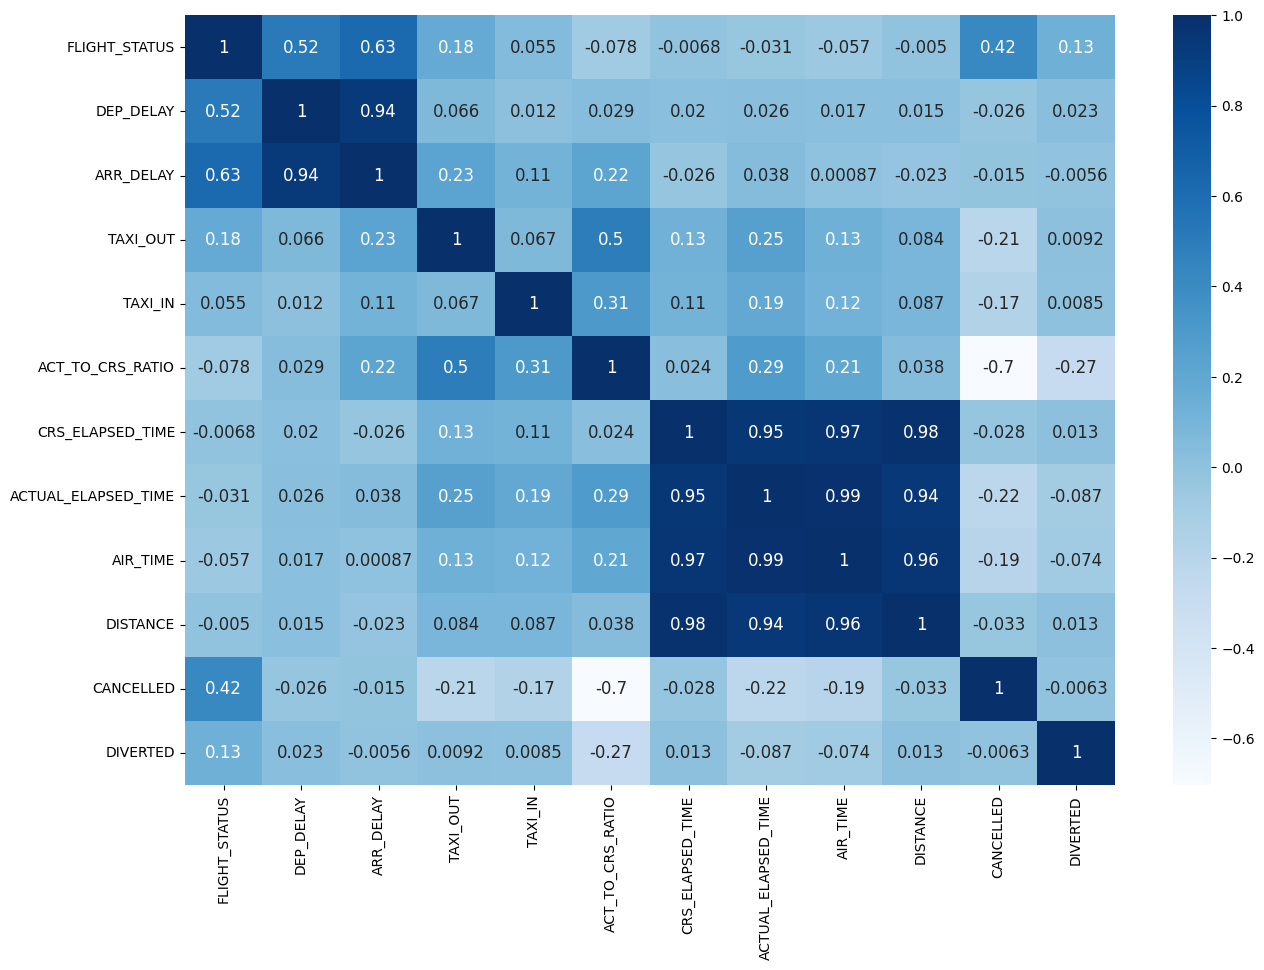

In [26]:
subset_cols = ['FLIGHT_STATUS', 'DEP_DELAY', 'ARR_DELAY', 'TAXI_OUT', 'TAXI_IN', 'ACT_TO_CRS_RATIO','CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CANCELLED', 'DIVERTED'] 

# Visualizza la heatmap per il sottoinsieme di colonne selezionato
plt.figure(figsize=(15, 10))
ax = sns.heatmap(df[subset_cols].corr(), cmap="Blues", annot=True, annot_kws={"size": 12})

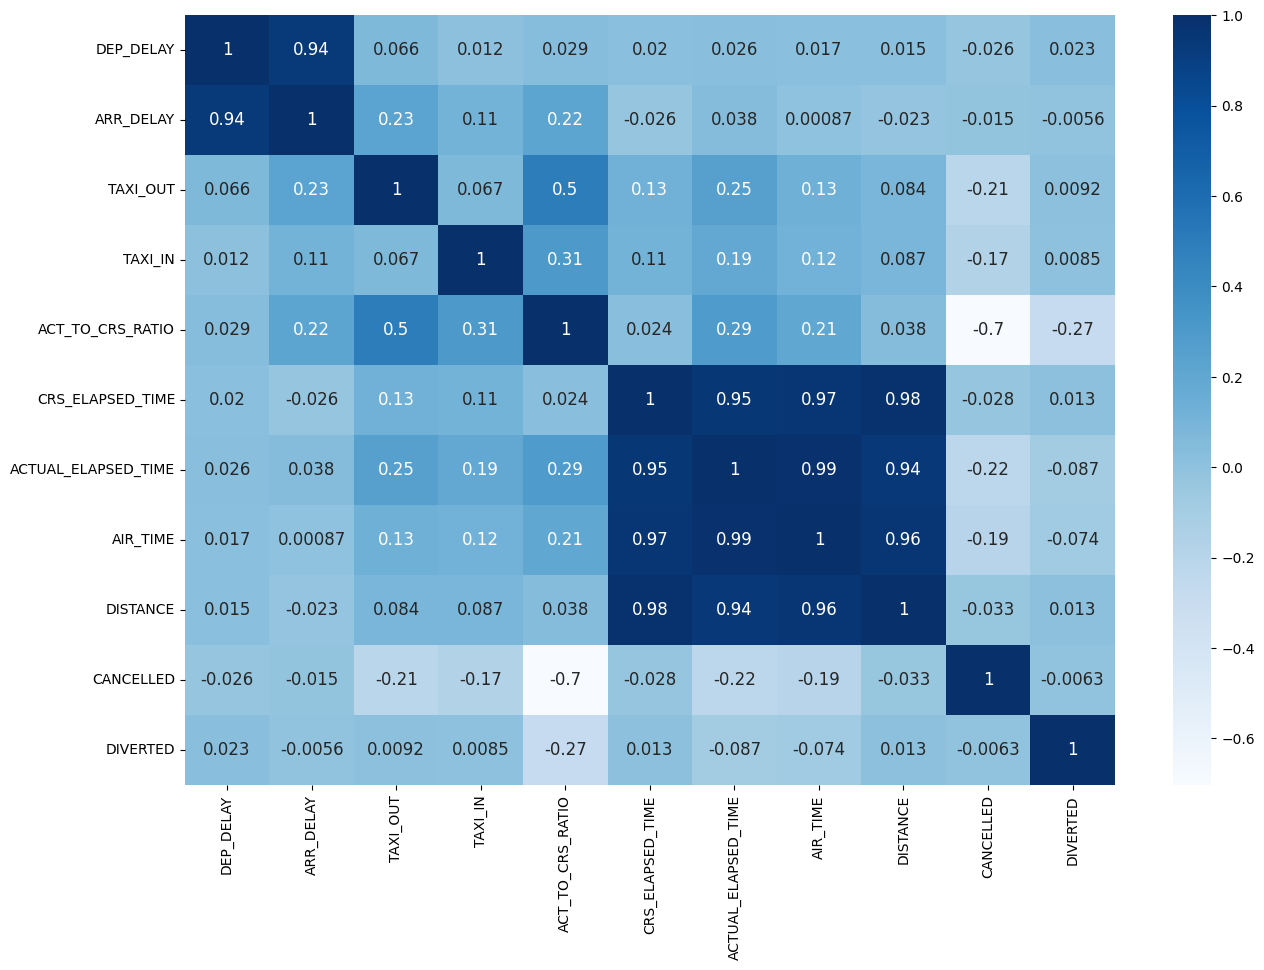

In [ ]:
# Visualizza la heatmap per il sottoinsieme di colonne selezionato
plt.figure(figsize=(15, 10))
ax = sns.heatmap(df[subset_cols].drop(columns=['FLIGHT_STATUS']).corr(), cmap="Blues", annot=True, annot_kws={"size": 12})

# Classificazione

In [27]:
y = df['FLIGHT_STATUS']
x = df.drop(columns=['FLIGHT_STATUS'])


# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(95416, 790)
(23855, 790)
(95416,)
(23855,)


## Training

In [28]:
classifiers = [
    LogisticRegression(random_state = rs),
    DecisionTreeClassifier(random_state=rs),
    RandomForestClassifier(n_estimators = 10, random_state=rs),
    GradientBoostingClassifier(random_state= rs),
    AdaBoostClassifier(n_estimators=10, random_state= rs),
    LinearDiscriminantAnalysis(),
    SVC(probability=True)
]

# List of results that will occure:
clf_name = [] # names of the classifiers
model_results = pd.DataFrame.copy(y_test) #resulting of prediction from the models

kfold = StratifiedKFold(n_splits=5) #cross-validation
cv_results = [] # scores from cross validation
cv_acc = [] # mean accuracy from cross validation, need to maximize
cv_std = [] # standard deviation from cross validation, need to minimise

cnfm = [] #confusion matrix
clr = [] #classification report
roc_auc = [] #roc curve:
roc_tpr = []
roc_fpr = []

In [ ]:
# Training the algorithms and results
for clf in classifiers:
    name = clf.__class__.__name__
    clf_name.append(name)
    
    #fitting and predictions
    model = clf.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    model_results[name] = y_pred
    
    #accuracy and log loss
    cv_results.append(cross_val_score(clf, x_train, y_train.values.ravel(), scoring = "accuracy",cv = kfold))
    acc = round(accuracy_score(y_test.values.ravel(), y_pred), 2) #need to maximize
    train_pred = clf.predict_proba(x_test)
    print(f'Accuracy: {acc} \t ---> {name} ')
    
    #confusion matrix, clasification report, roc curve
    cnfm.append(confusion_matrix(y_test.values.ravel(), y_pred))
    clr.append(classification_report(y_test.values.ravel(), y_pred))
    fpr, tpr, thresholds = roc_curve(y_pred, y_test.values.ravel(), pos_label=1)
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
    

for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())

c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Accuracy: 0.89 	 ---> LogisticRegression 
Accuracy: 1.0 	 ---> DecisionTreeClassifier 
Accuracy: 0.94 	 ---> RandomForestClassifier 


In [ ]:
# Cross validation accuracy results graph
cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})

plt.figure(figsize=(12,6))
sns.barplot(x="CrossValMeans",y="Algorithm",data = cv_res, palette="Set2",orient = "h",**{'xerr':cv_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")

In [ ]:
# Confusion matrixes (not-normalized confusion matrix)
plt.figure(figsize=(20,15))
sns.set(font_scale=1.4)
for i in range(len(classifiers)):
    plt.subplot(3,3,i+1) #adjust this acourding to the number of algorithms
    sns.heatmap(cnfm[i], annot=True, fmt="d",cmap="Reds")
    plt.subplots_adjust(hspace = 0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])

In [ ]:
#Classification reports
for i in range(len(classifiers)):
    print (f"{clf_name[i]} Classification Report:" )
    print (clr[i])

In [ ]:
# ROC Curve
plt.figure(figsize=(15,8))
for i in range(len(classifiers)):
    cm = ['red', 'blue', 'orange', 'green', 'pink', 'yellow', 'lightgreen', 'black', 'purple', 'lightblue'] #add more colours for more algorithms
    plt.plot(roc_fpr[i], roc_tpr[i], c=cm[i], lw=1, label=clf_name[i].replace("Classifier", "") + " (AUC = " + str(round(roc_auc[i],2)) + ")")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Receiver Operating Characteristic')
    plt.legend(loc="lower right")

## Testing